In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from tqdm import tqdm
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision.utils as vutils

#### Preprocessing the MNIST dataset

To normalize input data properly, we need to find the `mean` & `std` of the whole dataset.

In [2]:
dataset = datasets.MNIST(root='MNIST', download=True,transform=transforms.Compose([
    transforms.ToTensor(),  # Convert the image to `numpy.ndarray`
]))

mnist_mean, mnist_std = dataset.train_data.float().mean()/255, dataset.train_data.float().std()/255
print(f"MNIST mean={mnist_mean} & std={mnist_std}")

MNIST mean=0.13066047430038452 & std=0.30810779333114624


/Users/vladislav/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


#### Loading MNIST onto a DataLoader

In [3]:
image_size = 64
batch_size = 64

dataset = datasets.MNIST(root='MNIST', transform=transforms.Compose([
    transforms.Resize(size=image_size), # Interpolate original dataset to fit the provided size
    transforms.ToTensor(),  # Convert the image to `numpy.ndarray`
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

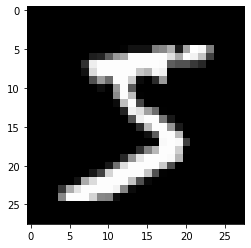

In [4]:
plt.imshow(dataset.data[0], cmap='gray')

In [5]:
# custom weights initialization based on DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
noise_size = 100
seed = 1
random.seed(seed)
torch.manual_seed(seed)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=noise_size, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(True),   
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.main(x)

In [8]:
generator = Generator()
generator.apply(weights_init)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)
        

In [10]:
discriminator = Discriminator()
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
real_label = 1.
fake_label = 0.

fixed_noise = torch.randn(size=(batch_size, noise_size, 1, 1))

In [12]:
loss = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(params=discriminator.parameters(), lr=0.0002)
optimizer_generator = torch.optim.Adam(params=generator.parameters(), lr=0.0002)

#### Training

In [15]:
loss_discriminator = []
loss_generator = []
images_from_fixed_noise = []
EPOCHS = 4
counter = 0

for epoch in range(EPOCHS):
    for i, batch_data in tqdm(enumerate(dataloader, 0)):
        # batch_data contains a pair of lists: < images `numpy.ndarray`, true labels >

        # #############################################
        # Training the Discriminator with a real batch
        discriminator.zero_grad()  # "PyTorch accumulates the gradients on subsequent backward passes"
        batch = batch_data[0].size(0)
        labels = torch.full(size=(batch,), fill_value=real_label, dtype=torch.float)  # list of ones
        discriminator_from_real_output = discriminator(batch_data[0]).view(-1)  # forward propagation
        loss_discriminator_from_real_samples = loss(discriminator_from_real_output, labels)  # calculate the loss
        loss_discriminator_from_real_samples.backward()  # back-propagate the gradient of the loss
        d_x = discriminator_from_real_output.mean().item()  # get the predicted ouput, should converge to 0.5
        
        # #############################################
        # Training the Discriminator with a fake batch
        fake_noise = torch.randn(size=(batch, noise_size, 1, 1))  # generate latent fake vectors
        fake_batch = generator(fake_noise)  # generate a fake batch of images by noise
        labels.fill_(value=fake_label)  # list of zeroes
        discriminator_from_fake_output = discriminator(fake_batch.detach()).view(-1)
        loss_discriminator_from_fake_samples = loss(discriminator_from_fake_output, labels)
        loss_discriminator_from_fake_samples.backward()  # back-propagate the gradient of the loss
        d_g_z_1 = loss_discriminator_from_fake_samples.mean().item()  # get the predicted ouput, should converge to 0.5

        loss_discriminator_from_real_and_fake_samples = loss_discriminator_from_real_samples + loss_discriminator_from_fake_samples
        optimizer_discriminator.step()

        # #############################################
        # Training the Generator with random noise
        generator.zero_grad()
        labels.fill_(value=real_label)
        generator_from_noise_output = discriminator(fake_batch).view(-1)
        loss_generator_from_noise = loss(generator_from_noise_output, labels)
        loss_generator_from_noise.backward()
        d_g_z_2 = loss_generator_from_noise.mean().item()
        optimizer_generator.step()

        # Accessibility
        loss_d = np.round(loss_discriminator_from_real_and_fake_samples.item(), 2)
        loss_g = np.round(loss_generator_from_noise.item(), 2)
        if i % 50 == 0:
            print(f"Epoch #{epoch} \t Loss_D={loss_d} \t Loss_G={loss_g} \t D(x)={d_x} \t D(G(z_1))={d_g_z_1} \t D(G(z_2))={d_g_z_2}")

        loss_discriminator.append(loss_discriminator_from_real_and_fake_samples.item())
        loss_generator.append(loss_generator_from_noise.item())

        if (counter % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            images_from_fixed_noise.append(vutils.make_grid(fake, padding=2, normalize=True))

        counter += 1

0it [00:00, ?it/s]

Epoch #0 	 Loss_D=0.0 	 Loss_G=11.9 	 D(x)=0.9999993443489075 	 D(G(z_1))=7.29880321159726e-06 	 D(G(z_2))=11.904664993286133


51it [02:17,  2.66s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.17 	 D(x)=0.9999988079071045 	 D(G(z_1))=5.597265044343658e-06 	 D(G(z_2))=12.169418334960938


101it [04:31,  2.62s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.17 	 D(x)=0.9999959468841553 	 D(G(z_1))=5.936269189987797e-06 	 D(G(z_2))=12.171107292175293


151it [06:45,  2.66s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.15 	 D(x)=0.9999969601631165 	 D(G(z_1))=5.6885351114033256e-06 	 D(G(z_2))=12.149041175842285


201it [09:01,  2.72s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=11.98 	 D(x)=0.9999991655349731 	 D(G(z_1))=6.825687250966439e-06 	 D(G(z_2))=11.983932495117188


251it [11:17,  2.71s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=11.98 	 D(x)=0.999999463558197 	 D(G(z_1))=6.823825060564559e-06 	 D(G(z_2))=11.978282928466797


301it [13:34,  2.75s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.03 	 D(x)=0.9999986290931702 	 D(G(z_1))=6.423352715501096e-06 	 D(G(z_2))=12.026905059814453


351it [15:55,  2.77s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=11.93 	 D(x)=0.9999983906745911 	 D(G(z_1))=7.1628292062086985e-06 	 D(G(z_2))=11.934114456176758


401it [18:14,  2.82s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=11.86 	 D(x)=0.9999980330467224 	 D(G(z_1))=7.669472324778326e-06 	 D(G(z_2))=11.861115455627441


451it [20:32,  2.76s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.03 	 D(x)=0.9999977350234985 	 D(G(z_1))=6.359091457852628e-06 	 D(G(z_2))=12.033803939819336


500it [22:48,  2.73s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.61 	 D(x)=0.9999988675117493 	 D(G(z_1))=3.673143282867386e-06 	 D(G(z_2))=12.611016273498535


551it [25:13,  3.17s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.69 	 D(x)=0.9999987483024597 	 D(G(z_1))=3.2708105663914466e-06 	 D(G(z_2))=12.688148498535156


601it [27:33,  2.80s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.69 	 D(x)=0.9999988675117493 	 D(G(z_1))=3.231694790883921e-06 	 D(G(z_2))=12.689228057861328


651it [29:52,  2.74s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.66 	 D(x)=0.9999995231628418 	 D(G(z_1))=3.404921244509751e-06 	 D(G(z_2))=12.657533645629883


701it [32:11,  2.78s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.8 	 D(x)=0.9999997019767761 	 D(G(z_1))=2.9131813334970502e-06 	 D(G(z_2))=12.799654006958008


751it [34:31,  2.77s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.91 	 D(x)=0.9999995827674866 	 D(G(z_1))=2.564866008469835e-06 	 D(G(z_2))=12.913614273071289


801it [36:52,  2.82s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.97 	 D(x)=0.999995768070221 	 D(G(z_1))=2.434480393276317e-06 	 D(G(z_2))=12.968132972717285


851it [39:13,  2.87s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.91 	 D(x)=0.9999997019767761 	 D(G(z_1))=2.5965307486330858e-06 	 D(G(z_2))=12.907063484191895


901it [41:34,  2.84s/it]

Epoch #0 	 Loss_D=0.0 	 Loss_G=12.89 	 D(x)=0.9999990463256836 	 D(G(z_1))=2.654272975632921e-06 	 D(G(z_2))=12.886539459228516


938it [43:20,  2.77s/it]
1it [00:05,  5.30s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.06 	 D(x)=0.9999980330467224 	 D(G(z_1))=2.2184128738444997e-06 	 D(G(z_2))=13.061188697814941


51it [02:27,  2.78s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.26 	 D(x)=0.9999992847442627 	 D(G(z_1))=1.7918662251759088e-06 	 D(G(z_2))=13.262421607971191


101it [04:49,  2.86s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.4 	 D(x)=0.9999982118606567 	 D(G(z_1))=1.5459966107300716e-06 	 D(G(z_2))=13.404848098754883


151it [07:12,  2.84s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.27 	 D(x)=0.9999997019767761 	 D(G(z_1))=1.8086302588926628e-06 	 D(G(z_2))=13.267890930175781


201it [09:36,  2.88s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.18 	 D(x)=0.9999964237213135 	 D(G(z_1))=1.9483286450849846e-06 	 D(G(z_2))=13.17833137512207


251it [12:04,  2.91s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.28 	 D(x)=0.9999998807907104 	 D(G(z_1))=1.7806904679673607e-06 	 D(G(z_2))=13.282920837402344


301it [14:37,  2.73s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.36 	 D(x)=0.9999994039535522 	 D(G(z_1))=1.6307471923937555e-06 	 D(G(z_2))=13.356117248535156


351it [16:59,  3.16s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.45 	 D(x)=0.9999994039535522 	 D(G(z_1))=1.5115376754692988e-06 	 D(G(z_2))=13.454423904418945


401it [19:21,  2.66s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.4 	 D(x)=0.9999995231628418 	 D(G(z_1))=1.5823181911400752e-06 	 D(G(z_2))=13.397616386413574


451it [21:31,  2.57s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.4 	 D(x)=0.999999463558197 	 D(G(z_1))=1.5674169162593898e-06 	 D(G(z_2))=13.39658260345459


501it [23:38,  2.54s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.49 	 D(x)=0.9999995231628418 	 D(G(z_1))=1.4202678357833065e-06 	 D(G(z_2))=13.494873046875


551it [25:45,  2.53s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.5 	 D(x)=0.9999996423721313 	 D(G(z_1))=1.4221305946193752e-06 	 D(G(z_2))=13.497613906860352


601it [27:53,  2.57s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.45 	 D(x)=0.9999992251396179 	 D(G(z_1))=1.4873231748424587e-06 	 D(G(z_2))=13.446834564208984


651it [30:00,  2.54s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.57 	 D(x)=0.9999995231628418 	 D(G(z_1))=1.3504186426871456e-06 	 D(G(z_2))=13.566129684448242


701it [32:07,  2.55s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.68 	 D(x)=0.9999998807907104 	 D(G(z_1))=1.1865057558679837e-06 	 D(G(z_2))=13.68384838104248


751it [34:12,  2.46s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.65 	 D(x)=0.9999997019767761 	 D(G(z_1))=1.2088574976587552e-06 	 D(G(z_2))=13.651644706726074


801it [36:15,  2.46s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.72 	 D(x)=0.999998927116394 	 D(G(z_1))=1.1334202554280637e-06 	 D(G(z_2))=13.721330642700195


851it [38:18,  2.46s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.71 	 D(x)=0.9999993443489075 	 D(G(z_1))=1.132489046540286e-06 	 D(G(z_2))=13.710609436035156


901it [40:20,  2.45s/it]

Epoch #1 	 Loss_D=0.0 	 Loss_G=13.83 	 D(x)=0.999999463558197 	 D(G(z_1))=1.016073383652838e-06 	 D(G(z_2))=13.831701278686523


938it [41:50,  2.68s/it]
1it [00:04,  4.31s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.87 	 D(x)=0.9999985694885254 	 D(G(z_1))=9.769578355189878e-07 	 D(G(z_2))=13.867162704467773


51it [02:06,  2.45s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.82 	 D(x)=0.9999998211860657 	 D(G(z_1))=1.024455400511215e-06 	 D(G(z_2))=13.824374198913574


101it [04:09,  2.45s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.61 	 D(x)=0.9999999403953552 	 D(G(z_1))=1.267530933546368e-06 	 D(G(z_2))=13.611611366271973


151it [06:12,  2.45s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.47 	 D(x)=0.9999995231628418 	 D(G(z_1))=1.464971546738525e-06 	 D(G(z_2))=13.469727516174316


201it [08:15,  2.45s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.65 	 D(x)=0.9999996423721313 	 D(G(z_1))=1.2218960137033719e-06 	 D(G(z_2))=13.650463104248047


251it [10:17,  2.45s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.83 	 D(x)=0.9999997615814209 	 D(G(z_1))=1.0095541256305296e-06 	 D(G(z_2))=13.8346586227417


301it [12:20,  2.44s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.67 	 D(x)=0.9999998807907104 	 D(G(z_1))=1.2116514653826016e-06 	 D(G(z_2))=13.6717529296875


351it [14:23,  2.45s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.66 	 D(x)=0.9999991655349731 	 D(G(z_1))=1.2116514653826016e-06 	 D(G(z_2))=13.657530784606934


401it [16:25,  2.43s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.67 	 D(x)=0.9999994039535522 	 D(G(z_1))=1.2014069170618313e-06 	 D(G(z_2))=13.66899585723877


451it [18:25,  2.46s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.48 	 D(x)=0.9999991655349731 	 D(G(z_1))=1.472422013648611e-06 	 D(G(z_2))=13.48022747039795


501it [20:28,  2.45s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.37 	 D(x)=0.9999992847442627 	 D(G(z_1))=1.6428546132374322e-06 	 D(G(z_2))=13.366823196411133


551it [22:30,  2.45s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.44 	 D(x)=0.9999988675117493 	 D(G(z_1))=1.5515845461777644e-06 	 D(G(z_2))=13.439863204956055


601it [24:33,  2.46s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.59 	 D(x)=0.9999997019767761 	 D(G(z_1))=1.3234102880232967e-06 	 D(G(z_2))=13.590757369995117


651it [26:36,  2.46s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.73 	 D(x)=0.9999988079071045 	 D(G(z_1))=1.1324889328534482e-06 	 D(G(z_2))=13.733847618103027


701it [28:39,  2.45s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.74 	 D(x)=0.9999999403953552 	 D(G(z_1))=1.1222444982195157e-06 	 D(G(z_2))=13.738651275634766


751it [30:41,  2.44s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.83 	 D(x)=0.9999997615814209 	 D(G(z_1))=1.0300433359589078e-06 	 D(G(z_2))=13.828693389892578


801it [32:44,  2.45s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.44 	 D(x)=0.9999997019767761 	 D(G(z_1))=1.518988142379385e-06 	 D(G(z_2))=13.4419584274292


851it [34:47,  2.46s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.53 	 D(x)=0.9999997615814209 	 D(G(z_1))=1.4109546100371517e-06 	 D(G(z_2))=13.533403396606445


901it [36:50,  2.46s/it]

Epoch #2 	 Loss_D=0.0 	 Loss_G=13.21 	 D(x)=0.999999463558197 	 D(G(z_1))=1.9837191302940482e-06 	 D(G(z_2))=13.214576721191406


938it [38:20,  2.45s/it]
1it [00:03,  3.97s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=12.83 	 D(x)=0.9999996423721313 	 D(G(z_1))=2.9364646252361126e-06 	 D(G(z_2))=12.825531959533691


51it [02:06,  2.45s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=13.1 	 D(x)=0.9999971985816956 	 D(G(z_1))=2.2882620669406606e-06 	 D(G(z_2))=13.102108001708984


101it [04:09,  2.45s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=12.81 	 D(x)=0.9999995231628418 	 D(G(z_1))=2.9094560431985883e-06 	 D(G(z_2))=12.813003540039062


151it [06:12,  2.46s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=13.2 	 D(x)=0.9999979138374329 	 D(G(z_1))=2.19047296923236e-06 	 D(G(z_2))=13.202710151672363


201it [08:15,  2.45s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=12.27 	 D(x)=0.9999996423721313 	 D(G(z_1))=6.398207460733829e-06 	 D(G(z_2))=12.271862030029297


251it [10:18,  2.47s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=11.47 	 D(x)=0.9999920129776001 	 D(G(z_1))=1.3586227396444883e-05 	 D(G(z_2))=11.474207878112793


301it [12:21,  2.45s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=12.4 	 D(x)=0.9999998807907104 	 D(G(z_1))=8.393115422222763e-06 	 D(G(z_2))=12.40412712097168


351it [14:23,  2.45s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=14.23 	 D(x)=0.9999980330467224 	 D(G(z_1))=1.2004755944872159e-06 	 D(G(z_2))=14.230920791625977


401it [16:26,  2.46s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=15.25 	 D(x)=0.9999768137931824 	 D(G(z_1))=1.6577541828155518e-07 	 D(G(z_2))=15.251399040222168


451it [18:29,  2.45s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=13.83 	 D(x)=0.9999997615814209 	 D(G(z_1))=1.1567034334802884e-06 	 D(G(z_2))=13.83238410949707


501it [20:32,  2.46s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=12.92 	 D(x)=0.9999973177909851 	 D(G(z_1))=3.5064356325165136e-06 	 D(G(z_2))=12.918811798095703


551it [22:35,  2.46s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=13.66 	 D(x)=0.9999948740005493 	 D(G(z_1))=1.241453787770297e-06 	 D(G(z_2))=13.659088134765625


601it [24:37,  2.46s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=13.22 	 D(x)=0.9999989867210388 	 D(G(z_1))=1.8812734197126701e-06 	 D(G(z_2))=13.223111152648926


651it [26:41,  2.45s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=14.32 	 D(x)=0.9999949932098389 	 D(G(z_1))=3.362074778578972e-07 	 D(G(z_2))=14.317117691040039


701it [28:44,  2.45s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=14.13 	 D(x)=0.9999997019767761 	 D(G(z_1))=8.400533602070936e-07 	 D(G(z_2))=14.129426956176758


751it [30:47,  2.47s/it]

Epoch #3 	 Loss_D=0.0 	 Loss_G=14.08 	 D(x)=0.9999993443489075 	 D(G(z_1))=1.018867465063522e-06 	 D(G(z_2))=14.0797700881958


801it [44:13, 46.53s/it]

Epoch #3 	 Loss_D=56.24 	 Loss_G=58.07 	 D(x)=5.592230026731095e-25 	 D(G(z_1))=0.0 	 D(G(z_2))=58.07221984863281


847it [1:19:46, 47.74s/it]